In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import linear_sum_assignment
import os
import skimage.transform as transform
import cv2
import sys

from read_metadata import read_metadata
%store -r vid_name
metadata = read_metadata(vid_name)

os.chdir(metadata.folder_code)
sys.path.append('./functions')
  
from koger_tracking import normalize, create_new_track, finalize_track, _get_boxes_center
from koger_tracking import calculate_distances, calculate_active_list
from koger_tracking import calculate_max_distance, calculate_active_list

    
plt.style.use('dark_background')

'GH944129'

In [3]:
score_thresh = .4

max_distance_threshold = 100 # was 70
# max distance for new tracks
max_distance_threshold_noise = 50
min_distance_threshold = 0
max_unseen_time = 90
min_new_track_distance = 20

# Change to 0 if want all tracks
min_length_threshold = 20



In [4]:
#f = open("demofile.txt", "r")
#print(f.read())


# list of dicts that contains keys "pred_boxes", "scores", "pred_classes", "image_name" for each frame
# Ignore if don't have
detections_file_name = "detections_" + vid_name + ".npy" 
detections_file = os.path.join(metadata.folder_output , detections_file_name)
detections_exist = os.path.isfile(detections_file)
if detections_exist:
    detections_dicts = np.load(detections_file, allow_pickle=True)
    print('using detections')


#Have the bounding boxes already been converted to postions
positions_file = os.path.join(metadata.folder_output, "positions_" + vid_name + ".npy")
positions_exists = os.path.isfile(positions_file)
if positions_exists:
    print('Using already computed postions.  Ignoring box files...')
    positions = np.load(positions_file, allow_pickle=True)
# positions_exists = False
    
tracks_file = os.path.join(metadata.folder_output, "tracks_" + vid_name + ".npy")
tracks_exists = os.path.isfile(tracks_file)
if tracks_exists:
    print('Tracks already exist')

using detections
Using already computed postions.  Ignoring box files...
Tracks already exist


In [29]:
if detections_exist:
    if not tracks_exists:
        for dict_ind, detection_dict in enumerate(detections_dicts):
            scores = detection_dict['scores']
            if positions_exists:
                positions[ind] = positions[ind][np.where(scores > score_thresh)]
            else:
                detections_dicts[dict_ind]['pred_boxes'] = detection_dict['pred_boxes'][np.where(scores > score_thresh)]
            detections_dicts[dict_ind]['pred_classes'] = detection_dict['pred_classes'][np.where(scores > score_thresh)]
            detections_dicts[dict_ind]['scores'] = detection_dict['scores'][np.where(scores > score_thresh)]

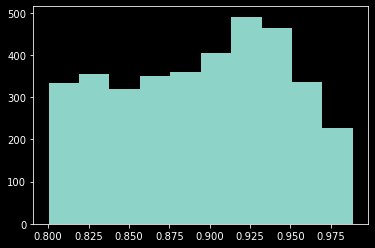

In [30]:
if detections_exist:
    low_scores = []
    for d_dict in detections_dicts:
        scores = d_dict['scores']
        if len(scores) != 0:
            if scores.min() < 1:
                for score in scores:
                    low_scores.append(score)
    #plt.hist(low_scores)

In [32]:
#get positions from boxes -> take the center of the box for the position
if detections_exist:
    if not positions_exists:
        positions = []

        for d_dict in detections_dicts:
            boxes = d_dict['pred_boxes']
            positions.append(_get_boxes_center(boxes))

        np.save(positions_file, positions)
        #print(len(positions))
        raw_positions = list(positions)

/home/baboonfield/anaconda3/envs/detectron2/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


average number of individuals 7.59375
most common number of individuals 8


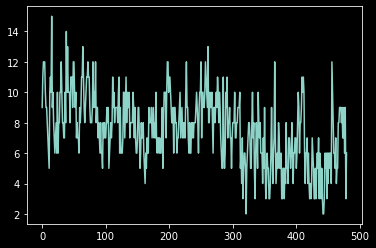

In [33]:
shape = []
for frame_positions in positions:
    shape.append(frame_positions.shape[0])
    
#plt.plot(shape)
#print('average number of individuals', sum(shape) / len(shape))

expected_individuals = max(set(shape), key=shape.count)

print('most common number of individuals', expected_individuals)

Let the cell below finish running before running the cells after

In [41]:
classes_exists = False

start_frame = 0 
end_frame = len(positions) 
range(positions[start_frame].shape[0])
ind=1

if classes_exists:
    class_label = classes_list[start_frame][ind]
    raw_track_list.append(create_new_track(start_frame, positions[start_frame][ind], ind, class_label, head_position, noise=0)) 


In [42]:
classes_exists = False

if not tracks_exists:
    raw_track_list = []
    

    class_label = None
    head_position = None

    start_frame = 0 
    end_frame = len(positions) 
#     end_frame = 30000

    #Create initial tracks based on the objects in the first frame
    for ind in range(positions[start_frame].shape[0]):
        #each track entry is both an array that store all points added to the track and a value that
        #indicates the frame on which the track begins

        if classes_exists:
            class_label = classes_list[start_frame][ind]
        raw_track_list.append(create_new_track(start_frame, positions[start_frame][ind], ind, class_label, head_position, noise=0)) 

    #try to connect points to the next frame
    for frame in range(start_frame + 1, end_frame):
        ###if frame % 100 == 0:
          ###  print('frame number', frame, 'processed')

        #get tracks that are still active (have been seen within the specified time)
        active_list = calculate_active_list(raw_track_list, max_unseen_time, frame)
        
        #positions from the next step
        positions1 = positions[frame]
        
        #No existing tracks to connect to
        if len(active_list) == 0:
            #Every point in next frame must start a new track
            if len(positions1) != 0:
                for position in range(positions1.shape[0]):
                    if classes_exists:
                        class_label = classes_list[frame][position]

                    raw_track_list.append(create_new_track(frame, positions1[position], position,                                                class_label, head_position))
            continue
            
        # To keep track of index of new points added for things like 
        # Keeping track of image locations, remove indexs that are already added
        positions1_indexes = np.arange(positions1.shape[0])
        
        # This will be changed linking information if points to connect
        # If not, will reamin empty
        row_ind_full = []
        
        # Make sure there are new points to add
        if len(positions1) != 0:

            raw_track_list = calculate_max_distance(raw_track_list, 
                                                    active_list, 
                                                    max_distance_threshold, 
                                                    max_distance_threshold_noise, 
                                                    min_distance_threshold)


            #returns an array of shape (len(active_list), positions1.shape[0])
            #row is distance from every new point to last point in row's active list 
            distance_raw = calculate_distances(positions1, raw_track_list, active_list)
#             if frame > 4000:
                
            
            max_distance = np.zeros_like(distance_raw)
            not_noise_tracks = np.ones(len(active_list))
            track_length = np.zeros(len(active_list))
            
            for active_num, track_num in enumerate(active_list):
                max_distance[active_num, :] = raw_track_list[track_num]['max_distance']
                track_length[active_num] = frame - raw_track_list[track_num]['first_frame']
                if raw_track_list[track_num]['noise'] > 0:
                    not_noise_tracks[active_num] = 0
            is_max_distance = distance_raw > max_distance
            new_track = np.all(is_max_distance, 0)

            new_track_ind = np.where(new_track)[0]
            if np.any(new_track):
                for t in new_track_ind:
                    if classes_exists:
                        class_label = classes_list[frame][t]

                    raw_track_list.append(create_new_track(frame, positions1[t], t, class_label, head_position)) 

            # Get rid of new points that are too far away and were just added as new tracks
            distance = np.delete(distance_raw, new_track_ind, 1)
            
            if distance.shape[1] > 0:
                # There are new points can be assigned to existing tracks
            
                # To keep track of index of new points added for things like 
                # Keeping track of image locations, remove indexs that are already added
                positions1_indexes = np.delete(positions1_indexes, new_track_ind)
                # Remove the new positions corresponding to added tracks
                positions1 = np.delete(positions1, new_track_ind, 0)

                #connect the dots from one frame to the next
                row_ind, col_ind = linear_sum_assignment(distance)


                row_ind_full = np.arange(len(active_list))
                col_ind_full = np.zeros(len(active_list), dtype=int)
                # In casese where there are fewer new points than existing tracks
                # some tracks won't get new point. Just assign them to the closest point
                duplicates = []
                to_delete = [] # less competive track for the same point, or nothing close
                for r_ind in row_ind_full:
                    if r_ind in row_ind:
                        # This track has been paired to a new point
                        col_ind_full[r_ind] = col_ind[np.where(row_ind == r_ind)]
                    else:
                        # This track wasn't assigned to a new point with the linear sum assignment
                        if np.min(distance[r_ind]) < raw_track_list[active_list[r_ind]]['max_distance']:
                            # There is a new point within this tracks assignment range
                            duplicates.append(np.argmin(distance[r_ind]))
                            col_ind_full[r_ind] = duplicates[-1]
                        else:
                            # This track wasn't assigned a new point and their isn't one close by
                            to_delete.append(r_ind)

                for duplicate in duplicates:
                    competing_tracks = np.squeeze(np.argwhere(col_ind_full == duplicate))
                    dominant_track_ind = np.argmax(track_length[competing_tracks])
                    # Tracks that want the same point but are shorter
                    to_delete.extend(competing_tracks[:dominant_track_ind])
                    if dominant_track_ind  < len(competing_tracks):
                        to_delete.extend(competing_tracks[dominant_track_ind+1:])
                to_delete_a  = np.array(to_delete)
                if np.any(to_delete_a):
                    col_ind_full = np.delete(col_ind_full, to_delete_a)
                    row_ind_full = np.delete(row_ind_full, to_delete_a)


                # CHANGE ROW_IND TO ROW_IND FULLL BELOW

                #see if points got assigned to tracks that are farther than max_threshold_distance
                #This happens when the closer track gets assigned to a differnt point
                bad_assign = distance[row_ind_full, col_ind_full] > max_distance[:, 0][row_ind_full]
                not_noise_tracks_used = not_noise_tracks[row_ind_full]
                if np.any(bad_assign):
                    bad_assign_points = np.where(bad_assign * not_noise_tracks_used)

                    #Assign multiple tracks to nearby points, in cases where track got assigned to somewhere far away
                    #because closer track got assigned to point first
                    #this case could come up when two animals get too close so they merge to one point
                    col_ind_full[bad_assign_points] = np.argmin(distance[row_ind_full[bad_assign_points],:], 1)

                    # There may be some tracks that just don't have any new points near by.  Now filter those out
                    valid_assign = distance[row_ind_full, col_ind_full] <= max_distance[:, 0][row_ind_full]
                    col_ind_full = col_ind_full[valid_assign]
                    row_ind_full = row_ind_full[valid_assign]

            
        active_list = np.array(active_list)
        

        for track_num in range(len(raw_track_list)):

            if track_num in active_list:
                
                #Case where there are new points in the next frame to add
                if track_num in active_list[row_ind_full] and len(positions1) != 0:
                    row_count = np.where(track_num == active_list[row_ind_full])[0]
                    # If this is a refound track, linearly interpolate from when last seen
                    if raw_track_list[track_num]['last_frame'] != frame - 1:
                        missed_steps = frame - raw_track_list[track_num]['last_frame'] - 1
                        gap_distance = (
                            positions1[col_ind_full[row_count[0]]] - raw_track_list[track_num]['track'][-1])
                        step_distance = gap_distance / (missed_steps + 1)
                        for step in range(missed_steps):
                            raw_track_list[track_num]['track'][-step - 1] = (
                                raw_track_list[track_num]['track'][-step - 1] + 
                                (missed_steps - step) * step_distance)

                    raw_track_list[track_num]['track'].append(positions1[col_ind_full[row_count[0]]])
                    raw_track_list[track_num]['pos_index'].append(positions1_indexes[col_ind_full[row_count[0]]])

                    raw_track_list[track_num]['last_frame'] = frame
                    if raw_track_list[track_num]['noise'] > 0:
                        raw_track_list[track_num]['noise'] -= 1
                    
                    
                        

                else:
                    raw_track_list[track_num]['track'].append(raw_track_list[track_num]['track'][-1])
                    raw_track_list[track_num]['pos_index'].append(np.nan)
                    # isn't a confirmed real track yet
                    if raw_track_list[track_num]['noise'] > 0:
                        raw_track_list[track_num]['noise'] += 1
        # Add new tracks for new points that weren't added to existing tracks but weren't far enough away before to aleady get a new track
        
        if distance.shape[0] < distance.shape[1]:
            # There are possible new points
            for pos1_ind in range(positions1.shape[0]):
                if pos1_ind in col_ind_full:
                    # This point was already added to an existing track
                    continue

                # Only add points that aren't too close to existing tracks 
                if np.min(distance_raw[:, positions1_indexes[pos1_ind]]) > min_new_track_distance:
                    # This new point isn't too close to existing tracks

                    if classes_exists:

                        class_label = classes_list[frame][positions1_indexes[pos1_ind]]

                    raw_track_list.append(create_new_track(
                        frame, positions1[pos1_ind], positions1_indexes[pos1_ind], class_label,                                head_position))
                                                            

            
                        
        # Traverse the list in reverse order so if there are multiple tracks that
        # need to be removed the indexing doesn't get messed up 
        for track_num in range(len(raw_track_list) - 1, -1, -1): 
            if raw_track_list[track_num]['noise'] >= 11:
                del raw_track_list[track_num]
                                                                  
                                                                  
                                                                  
    for track_ind, track in enumerate(raw_track_list):
        raw_track_list[track_ind] = finalize_track(track)
                                                                  
                                                                  

    for track in raw_track_list:
        #THIS IS THE PART THAT GETS RID OF THE EXTRA PART OF THE TRAIL
        #number of extra points at the end of track that were added hoping that the point would reapear 
        #nearby.  Since the tracking is now finished.  We can now get rid of these extra points tacked on to the end
        old_shape = track['track'].shape[0]
        track['track'] = track['track'][:track['last_frame'] - track['first_frame'] + 1]
        track['pos_index'] = track['pos_index'][:track['last_frame'] - track['first_frame'] + 1]

else:
    raw_track_list = tracks_list

print('detections to tracks processed')

detections to tracks processed


### Check resulting track length distribution and treshold out short tracks

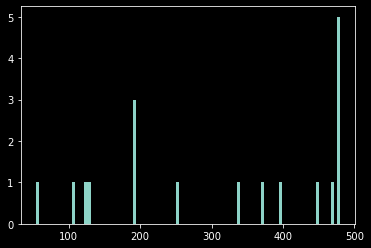

In [43]:
#print('number of tracks without min threshold' , len(raw_track_list))

track_lengths = []
track_list = []
for track_num, track in enumerate(raw_track_list):
    track_length = track['track'].shape[0]
    if track_length >= min_length_threshold:
        track_lengths.append(track['track'].shape[0])
        track_list.append(track)
    
#plt.hist(track_lengths, bins=100)
#plt.show()
#print('number of tracks above min threshold' , len(track_lengths))

In [44]:
# Average length of tracks after thresholding 
track_lengths = [track['track'].shape[0] for track in track_list]
average_length = sum(track_lengths) / len(track_lengths)
#print(average_length)

### Save tracks above length threshold

In [45]:
save = True

if save:
    np.save(tracks_file, track_list)

### draw some demo tracks

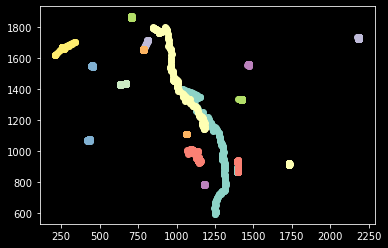

In [46]:
###for track in track_list[:30]:
###    plt.scatter(track['track'][:,0], track['track'][:,1])